In [1]:
%pip install ultralytics opencv-python matplotlib seaborn scikit-image scipy numpy pillow pyyaml

In [1]:
# ================================
# Step 0: 必要的导入
# ================================
import cv2
import os
import json
import shutil
import yaml
import numpy as np
from pathlib import Path
from tqdm import tqdm
from collections import defaultdict
from ultralytics import YOLO
import pandas as pd

In [2]:
# ================================
# Step 1: 数据集转换类 (COCO -> YOLO)
# ================================
class BeeDatasetProcessor:
    def __init__(self, dataset_path="bee-detection"):
        self.dataset_path = Path(dataset_path)
        self.yolo_dataset_path = Path("bee_yolo_dataset")
        self.class_names = {}

    def analyze_and_convert_dataset(self):
        """转换 COCO -> YOLO"""
        for split in ['train', 'valid', 'test']:
            (self.yolo_dataset_path / split / 'images').mkdir(parents=True, exist_ok=True)
            (self.yolo_dataset_path / split / 'labels').mkdir(parents=True, exist_ok=True)

        for split in ['train', 'valid', 'test']:
            self._convert_split(split)

        self._create_yaml_config()
        print("✅ 数据集转换完成")

    def _convert_split(self, split):
        coco_file = self.dataset_path / split / "_annotations.coco.json"
        images_dir = self.dataset_path / split / "images"

        if not coco_file.exists(): return
        with open(coco_file, 'r', encoding='utf-8') as f:
            coco_data = json.load(f)

        for cat in coco_data.get('categories', []):
            if cat['id'] > 0:
                self.class_names[cat['id']] = cat['name']

        images_info = {img['id']: img for img in coco_data.get('images', [])}
        anns = defaultdict(list)
        for ann in coco_data.get('annotations', []):
            if ann['category_id'] > 0:
                anns[ann['image_id']].append(ann)

        for image_id, image_info in tqdm(images_info.items(), desc=f"{split} 转换中"):
            src_img = images_dir / image_info['file_name']
            dst_img = self.yolo_dataset_path / split / 'images' / image_info['file_name']
            if not src_img.exists(): continue
            shutil.copy2(src_img, dst_img)

            w, h = image_info['width'], image_info['height']
            label_file = self.yolo_dataset_path / split / 'labels' / (Path(image_info['file_name']).stem + ".txt")
            with open(label_file, 'w', encoding='utf-8') as f:
                for ann in anns.get(image_id, []):
                    x, y, bw, bh = ann['bbox']
                    x_c = (x + bw/2) / w
                    y_c = (y + bh/2) / h
                    bw /= w
                    bh /= h
                    cls_id = ann['category_id'] - 1
                    f.write(f"{cls_id} {x_c:.6f} {y_c:.6f} {bw:.6f} {bh:.6f}\n")

    def _create_yaml_config(self):
        names = [self.class_names[k] for k in sorted(self.class_names.keys())]
        config = {
            'path': str(self.yolo_dataset_path.absolute()),
            'train': 'train/images',
            'val': 'valid/images',
            'test': 'test/images',
            'nc': len(names),
            'names': names
        }
        with open(self.yolo_dataset_path / 'dataset.yaml', 'w', encoding='utf-8') as f:
            yaml.dump(config, f, allow_unicode=True)


In [ ]:
# ================================
# Step 2: 图像处理方法
# ================================
class ImagePreprocessor:
    @staticmethod
    def hist_equalization(img):
        img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
        img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
        return cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)

    @staticmethod
    def sharpen(img):
        kernel = np.array([[0,-1,0],[-1,5,-1],[0,-1,0]])
        return cv2.filter2D(img, -1, kernel)

    @staticmethod
    def gamma_correction(img, gamma=0.75):
        invGamma = 1.0 / gamma
        table = np.array([(i / 255.0) ** invGamma * 255 for i in np.arange(256)]).astype("uint8")
        return cv2.LUT(img, table)

    @staticmethod
    def bilateral(img):
        return cv2.bilateralFilter(img, 9, 75, 75)

# 注册所有方法
PROCESSORS = {
    "hist": ImagePreprocessor.hist_equalization,
    "sharp": ImagePreprocessor.sharpen,
    "gamma": ImagePreprocessor.gamma_correction,
    "bilateral": ImagePreprocessor.bilateral
}

In [4]:
# ================================
# Step 3: 生成组合数据集
# ================================
class DatasetGenerator:
    def __init__(self, base_path="bee_yolo_dataset"):
        self.base_path = Path(base_path)
        self.output_root = Path("bee_processed_datasets")

    def generate_combinations(self):
        combos = [
            ("hist","sharp"),
            ("hist","gamma"),
            ("hist","bilateral"),
            ("sharp","gamma"),
            ("sharp","bilateral"),
            ("gamma","bilateral")
        ]
        for c1, c2 in combos:
            self._process_dataset(c1, c2)

    def _process_dataset(self, c1, c2):
        out_dir = self.output_root / f"{c1}_{c2}"
        for split in ["train", "valid", "test"]:
            (out_dir / split / "images").mkdir(parents=True, exist_ok=True)
            (out_dir / split / "labels").mkdir(parents=True, exist_ok=True)

            for label in (self.base_path / split / "labels").glob("*.txt"):
                shutil.copy2(label, out_dir / split / "labels" / label.name)

            for img_file in (self.base_path / split / "images").glob("*.*"):
                img = cv2.imread(str(img_file))
                if split in ["train","valid"]:   # 只处理 train 和 valid
                    img = PROCESSORS[c1](img)
                    img = PROCESSORS[c2](img)
                cv2.imwrite(str(out_dir / split / "images" / img_file.name), img)

        # 拷贝 yaml
        shutil.copy2(self.base_path / "dataset.yaml", out_dir / "dataset.yaml")

In [13]:
# ================================
# Step 4: 训练 & 结果收集 (修复版)
# ================================
import shutil
import gc
import torch
from pathlib import Path
import pandas as pd
from ultralytics import YOLO

class ExperimentRunner:
    def __init__(self, base_path="bee_yolo_dataset", processed_root="bee_processed_datasets"):
        self.base_path = Path(base_path)
        self.processed_root = Path(processed_root)
        self.results = []

    def _clear_cache(self, dataset_path: Path):
        """清理 YOLO 生成的 labels.cache 文件"""
        cache_files = [
            dataset_path / "train" / "labels.cache",
            dataset_path / "valid" / "labels.cache",
            dataset_path / "test" / "labels.cache"  # 也清理test缓存
        ]
        for f in cache_files:
            if f.exists():
                print(f"🧹 清理缓存: {f}")
                f.unlink()
        
        # 清理可能的隐藏缓存文件
        for cache_dir in [dataset_path / "train", dataset_path / "valid", dataset_path / "test"]:
            if cache_dir.exists():
                for cache_file in cache_dir.glob("*.cache"):
                    print(f"🧹 清理隐藏缓存: {cache_file}")
                    cache_file.unlink()

    def _validate_dataset_integrity(self, dataset_path: Path, dataset_name: str):
        """验证数据集完整性，确保不是空的或错误的数据集"""
        train_dir = dataset_path / "train"
        valid_dir = dataset_path / "valid"
        
        if not train_dir.exists() or not valid_dir.exists():
            print(f"❌ 数据集 {dataset_name} 缺少 train 或 valid 目录")
            return False
        
        # 检查图片数量
        train_images = list(train_dir.glob("images/*.jpg")) + list(train_dir.glob("images/*.png"))
        valid_images = list(valid_dir.glob("images/*.jpg")) + list(valid_dir.glob("images/*.png"))
        train_labels = list(train_dir.glob("labels/*.txt"))
        valid_labels = list(valid_dir.glob("labels/*.txt"))
        
        print(f"📊 数据集 {dataset_name} 统计:")
        print(f"   - 训练图片: {len(train_images)}")
        print(f"   - 训练标签: {len(train_labels)}")
        print(f"   - 验证图片: {len(valid_images)}")
        print(f"   - 验证标签: {len(valid_labels)}")
        
        if len(train_images) == 0:
            print(f"❌ 数据集 {dataset_name} 训练集为空")
            return False
        if len(valid_images) == 0:
            print(f"❌ 数据集 {dataset_name} 验证集为空")
            return False
        
        # 对于非baseline数据集，检查是否与baseline不同
        if dataset_name != "baseline":
            baseline_train = self.base_path / "train" / "images"
            if baseline_train.exists():
                baseline_images = list(baseline_train.glob("*.jpg")) + list(baseline_train.glob("*.png"))
                if len(train_images) == len(baseline_images):
                    print(f"⚠️  警告: 数据集 {dataset_name} 的图片数量与 baseline 相同，可能没有正确处理")
                    # 检查第一张图片是否相同
                    if train_images and baseline_images:
                        import hashlib
                        def get_file_hash(filepath):
                            with open(filepath, 'rb') as f:
                                return hashlib.md5(f.read()).hexdigest()
                        
                        if get_file_hash(train_images[0]) == get_file_hash(baseline_images[0]):
                            print(f"❌ 数据集 {dataset_name} 与 baseline 完全相同！")
                            return False
        
        return True

    def _regenerate_dataset_yaml(self, dataset_path: Path):
        """重新生成 dataset.yaml 文件，确保路径正确"""
        yaml_file = dataset_path / "dataset.yaml"
        
        # 获取绝对路径
        train_path = (dataset_path / "train").resolve()
        val_path = (dataset_path / "valid").resolve()
        
        # 创建新的配置
        config = {
            'train': str(train_path),
            'val': str(val_path),
            'nc': 1,  # bee detection 只有一个类别
            'names': ['bee']
        }
        
        # 备份原文件（如果存在）
        if yaml_file.exists():
            backup_file = yaml_file.with_suffix('.yaml.backup')
            if not backup_file.exists():
                shutil.copy2(yaml_file, backup_file)
                print(f"📄 已备份原配置文件到: {backup_file}")
        
        # 写入新配置
        import yaml
        with open(yaml_file, 'w') as f:
            yaml.dump(config, f, default_flow_style=False)
        
        print(f"✅ 已重新生成数据集配置文件:")
        print(f"   - 训练集: {config['train']}")
        print(f"   - 验证集: {config['val']}")
        
        return True

    def _force_cleanup(self):
        """强制清理内存和GPU缓存"""
        import gc
        import torch
        
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            torch.cuda.synchronize()  # 等待所有CUDA操作完成
            
            # 打印当前GPU内存使用情况
            if torch.cuda.is_available():
                allocated = torch.cuda.memory_allocated() / 1024**3  # GB
                reserved = torch.cuda.memory_reserved() / 1024**3   # GB
                print(f"🔧 GPU内存: 已分配 {allocated:.2f}GB, 已预留 {reserved:.2f}GB")
    
    def _check_cuda_memory(self, batch_size, imgsz):
        """检查CUDA内存并建议合适的batch size"""
        import torch
        
        if not torch.cuda.is_available():
            return batch_size
            
        # 获取GPU内存信息
        total_memory = torch.cuda.get_device_properties(0).total_memory / 1024**3  # GB
        allocated = torch.cuda.memory_allocated() / 1024**3  # GB
        reserved = torch.cuda.memory_reserved() / 1024**3   # GB
        free_memory = total_memory - reserved
        
        print(f"🔍 GPU内存检查:")
        print(f"   - 总内存: {total_memory:.2f}GB")
        print(f"   - 已分配: {allocated:.2f}GB") 
        print(f"   - 已预留: {reserved:.2f}GB")
        print(f"   - 可用内存: {free_memory:.2f}GB")
        
        # 根据可用内存调整batch size
        estimated_memory_per_batch = (imgsz * imgsz * 3 * batch_size) / (1024**3) * 4  # 粗略估算
        
        if estimated_memory_per_batch > free_memory * 0.8:  # 留20%缓冲
            suggested_batch = int(batch_size * (free_memory * 0.8) / estimated_memory_per_batch)
            suggested_batch = max(1, suggested_batch)
            print(f"⚠️  建议降低batch size: {batch_size} -> {suggested_batch}")
            return suggested_batch
        
        return batch_size

    def run_all(self, epochs=50, imgsz=640, batch=16, start_from=None, skip_completed=True):
        # 先收集所有处理过的数据集（排除 baseline）
        datasets = []
        
        # 确保processed_root存在
        if not self.processed_root.exists():
            print(f"⚠️  处理后的数据集目录不存在: {self.processed_root}")
            return
            
        for d in self.processed_root.iterdir():
            if d.is_dir() and d.name != "baseline":
                datasets.append((d.name, d))
        
        # baseline 放到最后，使用原始路径
        datasets.append(("baseline", self.base_path))
        
        # 如果指定了开始位置，从该位置开始
        if start_from:
            start_idx = -1
            for i, (name, _) in enumerate(datasets):
                if name == start_from:
                    start_idx = i
                    break
            
            if start_idx == -1:
                print(f"❌ 找不到指定的起始数据集: {start_from}")
                print(f"可用的数据集: {[name for name, _ in datasets]}")
                return
            else:
                datasets = datasets[start_idx:]
                print(f"🎯 从数据集 '{start_from}' 开始训练")
        
        # 检查已完成的训练（如果启用跳过功能）
        completed_datasets = set()
        if skip_completed:
            runs_dir = Path("runs/experiments")
            if runs_dir.exists():
                completed_datasets = {d.name.replace('_exp', '') for d in runs_dir.iterdir() 
                                    if d.is_dir() and d.name.endswith('_exp')}
                if completed_datasets:
                    print(f"🔍 发现已完成的训练: {completed_datasets}")
        
        print(f"📊 准备训练 {len(datasets)} 个数据集:")
        for name, path in datasets:
            status = "✅ (已完成)" if name in completed_datasets else "⏳ (待训练)"
            print(f"   - {name}: {path} {status}")

        total = len(datasets)

        for idx, (name, ds_path) in enumerate(datasets, start=1):
            # 如果启用跳过功能且该数据集已完成，跳过
            if skip_completed and name in completed_datasets:
                print(f"\n⏭️  [{idx}/{total}] 跳过已完成的数据集: {name}")
                continue
                
            print(f"\n{'='*60}")
            print(f"🚀 [{idx}/{total}] 开始训练数据集: {name}")
            print(f"📁 数据集路径: {ds_path}")
            print(f"{'='*60}")

            # 验证数据集完整性
            if not self._validate_dataset_integrity(ds_path, name):
                print(f"❌ 跳过数据集 {name}: 数据集无效或与baseline相同")
                continue

            # 重新生成数据集配置文件（确保路径绝对正确）
            self._regenerate_dataset_yaml(ds_path)

            # 训练前强制清理
            self._force_cleanup()
            self._clear_cache(ds_path)
            
            # 检查CUDA内存并调整batch size
            adjusted_batch = self._check_cuda_memory(batch, imgsz)
            if adjusted_batch != batch:
                print(f"📉 自动调整batch size: {batch} -> {adjusted_batch}")
                current_batch = adjusted_batch
            else:
                current_batch = batch

            try:
                # 每次都创建全新的模型实例
                print(f"🔄 创建新的 YOLO 模型...")
                model = YOLO("yolov8n.pt")
                
                # 确保使用绝对路径
                yaml_path = str(ds_path.resolve() / "dataset.yaml")
                print(f"📋 使用配置文件: {yaml_path}")
                
                # 训练
                print(f"🏋️  开始训练...")
                res = model.train(
                    data=yaml_path,
                    epochs=epochs,
                    imgsz=imgsz,
                    batch=current_batch,
                    augment=False,      # 关闭数据增强
                    cache=False,        # 禁止使用缓存
                    project="runs/experiments",
                    name=f"{name}_exp", # 确保每个实验有唯一名称
                    exist_ok=True,
                    verbose=True,       # 详细输出
                    save=True,
                    plots=True
                )
                
                print(f"✅ 训练完成，开始验证...")
                # 验证
                metrics = model.val(
                    data=yaml_path,
                    save_json=True,
                    verbose=True
                )
                
                # 收集结果
                results_dict = metrics.results_dict
                self.results.append({
                    "dataset": name,
                    "dataset_path": str(ds_path),
                    "precision": results_dict.get("metrics/precision(B)", 0.0),
                    "recall": results_dict.get("metrics/recall(B)", 0.0), 
                    "mAP50": results_dict.get("metrics/mAP50(B)", 0.0),
                    "mAP50-95": results_dict.get("metrics/mAP50-95(B)", 0.0),
                    "epochs": epochs,
                    "batch_size": current_batch,
                    "img_size": imgsz
                })
                
                print(f"✅ 数据集 {name} 训练完成!")
                print(f"   - Precision: {self.results[-1]['precision']:.4f}")
                print(f"   - Recall: {self.results[-1]['recall']:.4f}")
                print(f"   - mAP50: {self.results[-1]['mAP50']:.4f}")
                print(f"   - mAP50-95: {self.results[-1]['mAP50-95']:.4f}")
                
                # 训练后清理
                del model
                self._force_cleanup()
                
            except Exception as e:
                print(f"❌ 训练数据集 {name} 时出错: {e}")
                self.results.append({
                    "dataset": name,
                    "dataset_path": str(ds_path),
                    "precision": 0.0,
                    "recall": 0.0,
                    "mAP50": 0.0,
                    "mAP50-95": 0.0,
                    "epochs": epochs,
                    "batch_size": current_batch,
                    "img_size": imgsz,
                    "error": str(e)
                })
                self._force_cleanup()
                continue

        print(f"\n{'='*60}")
        print("✅ 所有训练完成！")
        print(f"{'='*60}")

    def resume_training(self, start_from="sharp_bilateral", epochs=50, imgsz=640, batch=8):
        """从指定数据集恢复训练，使用更保守的参数"""
        print(f"🔄 恢复训练，从 {start_from} 开始")
        print(f"⚙️  使用保守参数: epochs={epochs}, imgsz={imgsz}, batch={batch}")
        
        # 强制清理内存
        self._force_cleanup()
        
        # 从指定位置开始训练
        self.run_all(
            epochs=epochs, 
            imgsz=imgsz, 
            batch=batch, 
            start_from=start_from,
            skip_completed=True
        )
        
    def save_results(self):
        """保存实验结果"""
        from datetime import datetime
        
        if not self.results:
            print("⚠️  没有结果可保存")
            return
            
        df = pd.DataFrame(self.results)
        
        # 添加时间戳到文件名
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"results_summary_{timestamp}.csv"
        
        df.to_csv(filename, index=False)
        print(f"✅ 结果已保存到 {filename}")
        
        # 显示结果摘要
        print("\n📊 实验结果摘要:")
        print("="*80)
        for _, row in df.iterrows():
            if 'error' not in row or pd.isna(row.get('error')):
                print(f"{row['dataset']:15} | P:{row['precision']:.4f} | R:{row['recall']:.4f} | mAP50:{row['mAP50']:.4f} | mAP50-95:{row['mAP50-95']:.4f}")
            else:
                print(f"{row['dataset']:15} | ERROR: {row.get('error', 'Unknown error')}")
        print("="*80)
        
        return df

    def plot_results(self):
        """绘制结果对比图"""
        if not self.results:
            print("⚠️  没有结果可绘制")
            return
            
        import matplotlib.pyplot as plt
        
        df = pd.DataFrame(self.results)
        # 过滤掉有错误的结果
        df_clean = df[~df.get('error', pd.Series(dtype=object)).notna()]
        
        if df_clean.empty:
            print("⚠️  没有有效的结果可绘制")
            return
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('YOLO Training Results Comparison', fontsize=16)
        
        metrics = ['precision', 'recall', 'mAP50', 'mAP50-95']
        titles = ['Precision', 'Recall', 'mAP@0.5', 'mAP@0.5:0.95']
        
        for i, (metric, title) in enumerate(zip(metrics, titles)):
            ax = axes[i//2, i%2]
            bars = ax.bar(df_clean['dataset'], df_clean[metric])
            ax.set_title(title)
            ax.set_ylabel('Score')
            ax.tick_params(axis='x', rotation=45)
            
            # 添加数值标签
            for bar in bars:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                       f'{height:.3f}', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()

In [ ]:
# Step 1: 转换 COCO -> YOLO
processor = BeeDatasetProcessor("bee-detection")
processor.analyze_and_convert_dataset()

In [45]:
# Step 2: 生成组合数据集
gen = DatasetGenerator("bee_yolo_dataset")
gen.generate_combinations()

In [15]:
runner = ExperimentRunner(
    base_path="bee_yolo_dataset", 
    processed_root="bee_processed_datasets"
)

# 从 sharp_bilateral 开始
runner.resume_training(
    start_from="sharp_bilateral", 
    epochs=50, 
    imgsz=640, 
    batch=16 
)

🔄 恢复训练，从 sharp_bilateral 开始
⚙️  使用保守参数: epochs=50, imgsz=640, batch=16
🔧 GPU内存: 已分配 0.03GB, 已预留 0.03GB
🎯 从数据集 'sharp_bilateral' 开始训练
🔍 发现已完成的训练: {'hist_sharp', 'hist_gamma', 'hist_bilateral', 'baseline', 'gamma_bilateral'}
📊 准备训练 3 个数据集:
   - sharp_bilateral: bee_processed_datasets\sharp_bilateral ⏳ (待训练)
   - sharp_gamma: bee_processed_datasets\sharp_gamma ⏳ (待训练)
   - baseline: bee_yolo_dataset ✅ (已完成)

🚀 [1/3] 开始训练数据集: sharp_bilateral
📁 数据集路径: bee_processed_datasets\sharp_bilateral
📊 数据集 sharp_bilateral 统计:
   - 训练图片: 6721
   - 训练标签: 6721
   - 验证图片: 1914
   - 验证标签: 1914
⚠️  警告: 数据集 sharp_bilateral 的图片数量与 baseline 相同，可能没有正确处理
📄 已备份原配置文件到: bee_processed_datasets\sharp_bilateral\dataset.yaml.backup
✅ 已重新生成数据集配置文件:
   - 训练集: D:\学校\数字图像\Bee Detection\bee_processed_datasets\sharp_bilateral\train
   - 验证集: D:\学校\数字图像\Bee Detection\bee_processed_datasets\sharp_bilateral\valid
🔧 GPU内存: 已分配 0.03GB, 已预留 0.03GB
🧹 清理缓存: bee_processed_datasets\sharp_bilateral\train\labels.cache
🧹 清理缓存: bee_proces

In [ ]:
import pandas as pd
from pathlib import Path

def collect_results_from_csv():
    """从已有的results.csv文件收集结果"""
    results = []
    runs_dir = Path("runs/experiments")
    
    if not runs_dir.exists():
        print("❌ 没找到 runs/experiments 目录")
        return []
    
    # 找到所有训练目录
    train_dirs = [d for d in runs_dir.iterdir() if d.is_dir()]
    print(f"📁 发现 {len(train_dirs)} 个训练目录")
    
    for train_dir in train_dirs:
        dataset_name = train_dir.name.replace('_exp', '')  # 去掉_exp后缀
        results_csv = train_dir / "results.csv"
        
        print(f"🔍 处理: {dataset_name}")
        
        if not results_csv.exists():
            print(f"   ❌ 没找到 results.csv")
            continue
        
        try:
            # 读取results.csv
            df = pd.read_csv(results_csv)
            
            # 取最后一行（最终结果）
            last_row = df.iloc[-1]
            
            # 提取指标
            result = {
                "dataset": dataset_name,
                "precision": last_row.get('metrics/precision(B)', 0.0),
                "recall": last_row.get('metrics/recall(B)', 0.0),
                "mAP50": last_row.get('metrics/mAP50(B)', 0.0),
                "mAP50-95": last_row.get('metrics/mAP50-95(B)', 0.0),
                "epochs": len(df)  # 总epoch数
            }
            
            results.append(result)
            print(f"   ✅ mAP50: {result['mAP50']:.4f} ({result['epochs']} epochs)")
            
        except Exception as e:
            print(f"   ❌ 读取失败: {e}")
    
    return results

def save_and_plot_results(results):
    """保存结果并绘图"""
    if not results:
        print("⚠️ 没有结果")
        return
    
    # 保存CSV
    df = pd.DataFrame(results)
    filename = "all_results.csv"
    df.to_csv(filename, index=False)
    print(f"✅ 保存到: {filename}")
    
    # 打印表格
    print("\n📊 结果汇总:")
    print("="*75)
    print(f"{'数据集':<15} {'Precision':<10} {'Recall':<10} {'mAP50':<10} {'mAP50-95':<10} {'Epochs':<8}")
    print("="*75)
    for _, row in df.iterrows():
        print(f"{row['dataset']:<15} {row['precision']:<10.4f} {row['recall']:<10.4f} {row['mAP50']:<10.4f} {row['mAP50-95']:<10.4f} {row['epochs']:<8}")
    print("="*75)
    
    # 按mAP50排序显示排名
    df_sorted = df.sort_values('mAP50', ascending=False)
    print(f"\n🏆 按 mAP50 排名:")
    for i, (_, row) in enumerate(df_sorted.iterrows(), 1):
        print(f"{i:2}. {row['dataset']:<15} - mAP50: {row['mAP50']:.4f}")
    
    # 简单绘图
    import matplotlib.pyplot as plt
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    fig.suptitle('训练结果对比', fontsize=14)
    
    metrics = ['precision', 'recall', 'mAP50', 'mAP50-95']
    titles = ['Precision', 'Recall', 'mAP@0.5', 'mAP@0.5:0.95']
    
    for i, (metric, title) in enumerate(zip(metrics, titles)):
        ax = axes[i//2, i%2]
        bars = ax.bar(df['dataset'], df[metric])
        ax.set_title(title)
        ax.tick_params(axis='x', rotation=45)
        
        # 添加数值标签
        for j, v in enumerate(df[metric]):
            ax.text(j, v + 0.01, f'{v:.3f}', ha='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    return df

📁 发现 7 个训练目录
🔍 处理: baseline
   ✅ mAP50: 0.8215 (50 epochs)
🔍 处理: gamma_bilateral
   ✅ mAP50: 0.8223 (100 epochs)
🔍 处理: hist_bilateral
   ✅ mAP50: 0.8034 (100 epochs)
🔍 处理: hist_gamma
   ✅ mAP50: 0.8170 (100 epochs)
🔍 处理: hist_sharp
   ✅ mAP50: 0.7669 (100 epochs)
🔍 处理: sharp_bilateral
   ✅ mAP50: 0.7928 (50 epochs)
🔍 处理: sharp_gamma
   ✅ mAP50: 0.8011 (50 epochs)
✅ 保存到: all_results.csv

📊 结果汇总:
数据集             Precision  Recall     mAP50      mAP50-95   Epochs  
baseline        0.8154     0.7884     0.8215     0.3675     50      
gamma_bilateral 0.8124     0.7824     0.8223     0.3711     100     
hist_bilateral  0.8202     0.7629     0.8034     0.3544     100     
hist_gamma      0.8223     0.7760     0.8170     0.3593     100     
hist_sharp      0.8037     0.7260     0.7669     0.3390     100     
sharp_bilateral 0.8178     0.7490     0.7928     0.3502     50      
sharp_gamma     0.8213     0.7550     0.8011     0.3552     50      

🏆 按 mAP50 排名:
 1. gamma_bilateral - mAP50: 0.8223

C:\Users\22852\AppData\Local\Temp\ipykernel_20352\764822531.py:98: UserWarning: Glyph 35757 (\N{CJK UNIFIED IDEOGRAPH-8BAD}) missing from current font.
  plt.tight_layout()
C:\Users\22852\AppData\Local\Temp\ipykernel_20352\764822531.py:98: UserWarning: Glyph 32451 (\N{CJK UNIFIED IDEOGRAPH-7EC3}) missing from current font.
  plt.tight_layout()
C:\Users\22852\AppData\Local\Temp\ipykernel_20352\764822531.py:98: UserWarning: Glyph 32467 (\N{CJK UNIFIED IDEOGRAPH-7ED3}) missing from current font.
  plt.tight_layout()
C:\Users\22852\AppData\Local\Temp\ipykernel_20352\764822531.py:98: UserWarning: Glyph 26524 (\N{CJK UNIFIED IDEOGRAPH-679C}) missing from current font.
  plt.tight_layout()
C:\Users\22852\AppData\Local\Temp\ipykernel_20352\764822531.py:98: UserWarning: Glyph 23545 (\N{CJK UNIFIED IDEOGRAPH-5BF9}) missing from current font.
  plt.tight_layout()
C:\Users\22852\AppData\Local\Temp\ipykernel_20352\764822531.py:98: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing fr

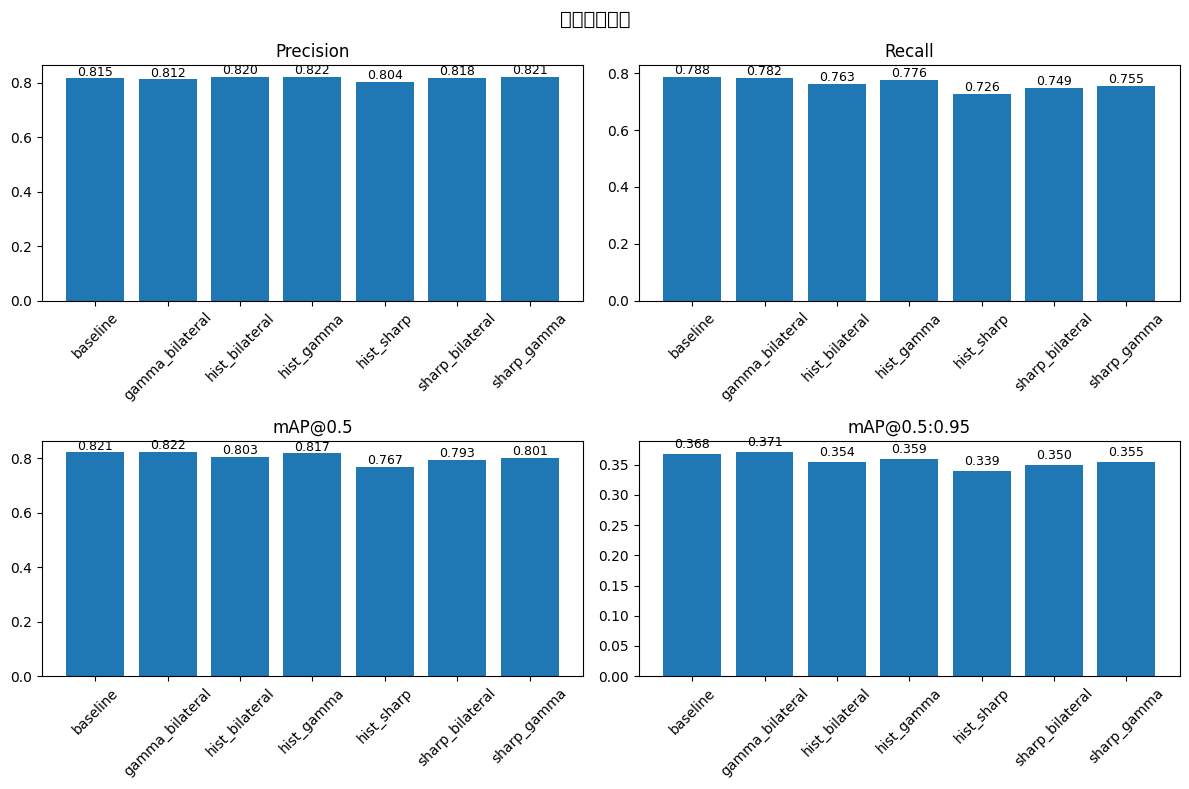

In [11]:
# 从CSV文件收集所有训练结果
results = collect_results_from_csv()
df = save_and_plot_results(results)